## Решающие деревья, случайные леса и градиентный бустинг

### О задании

Задание состоит из трёх разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.  
3. В третьем разделе вы попробуете градиентный бустинг на практической задаче.

Прежде чем приступать к работе, рекомендую прочитать теорию.  
Построение решающего дерева осуществляется согласно базовому жадному алгоритму, описанному в [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Построение случайного леса описано в лекции [8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture08-ensembles.pdf), про градиентный бустинг [9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf), про стекинг и блендинг в лекции  [10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [109]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0., )
]

In [110]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

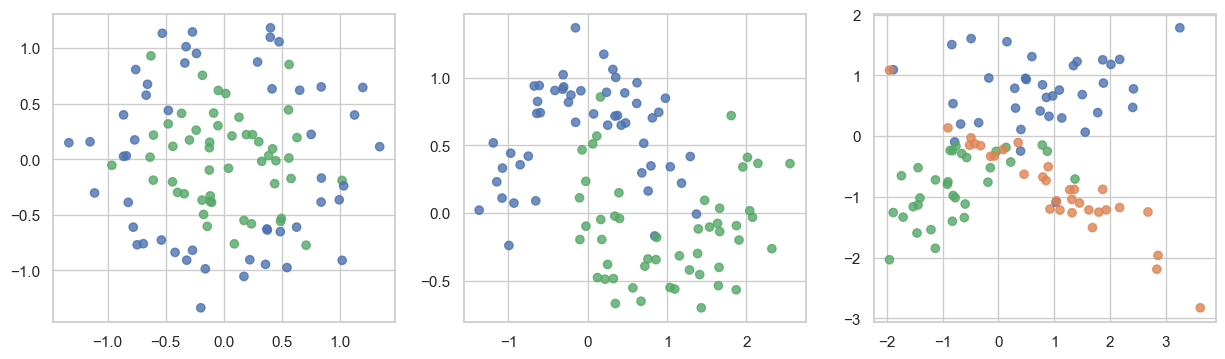

In [111]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1.1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [112]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

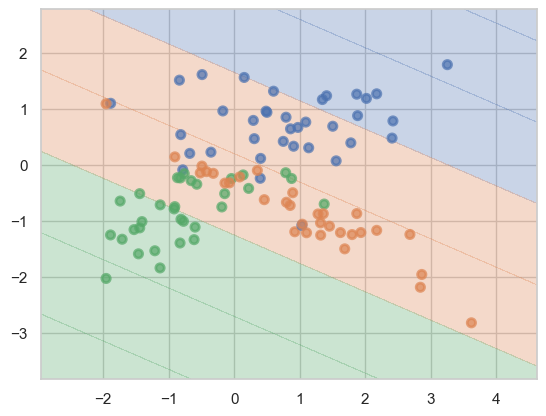

In [113]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

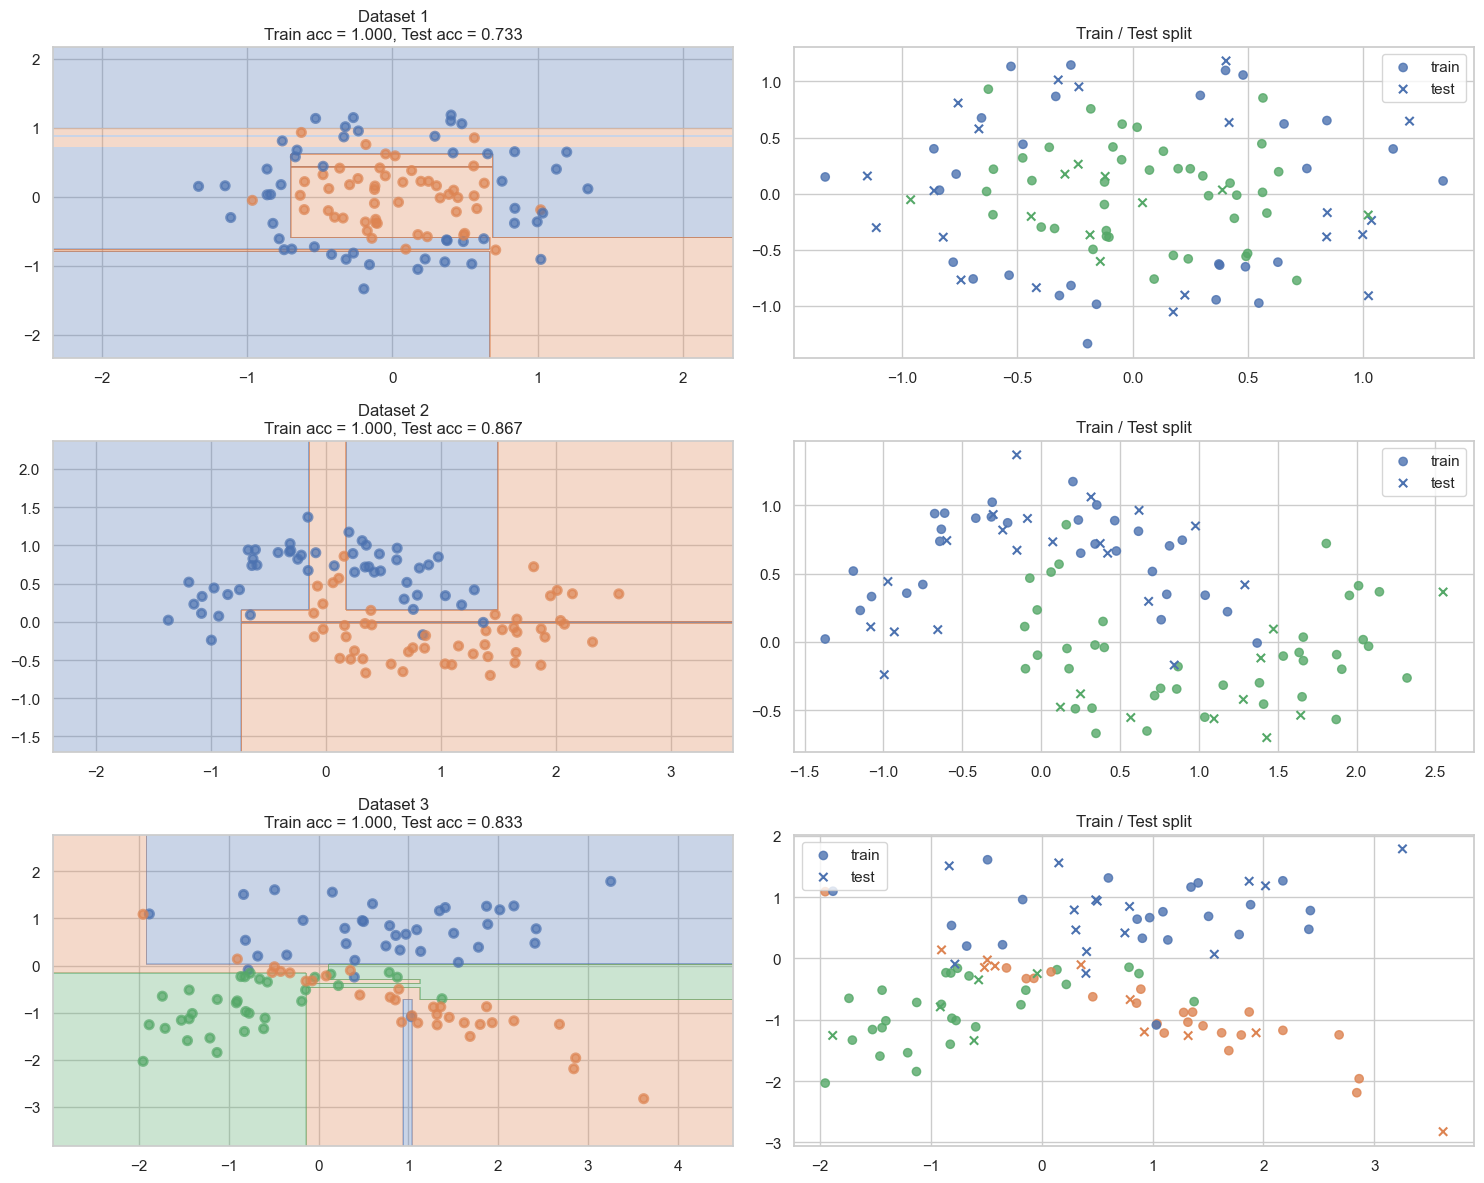

In [114]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(15, 12))

for i, (X, y) in enumerate(datasets):
    # 1. Разбиение
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # 2. Обучение дерева
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # 3. Accuracy
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))

    # 4. Визуализация
    plt.subplot(3, 2, 2 * i + 1)
    plot_surface(clf, X, y)
    plt.title(
        f"Dataset {i + 1}\n"
        f"Train acc = {train_acc:.3f}, Test acc = {test_acc:.3f}"
    )

    # Отдельно точки train/test
    plt.subplot(3, 2, 2 * i + 2)
    plt.scatter(
        X_train[:, 0], X_train[:, 1],
        c=y_train, cmap=cmap, alpha=0.8, label="train"
    )
    plt.scatter(
        X_test[:, 0], X_test[:, 1],
        c=y_test, cmap=cmap, marker="x", label="test"
    )
    plt.legend()
    plt.title("Train / Test split")

plt.tight_layout()


__Ответ:__

Для всех датасетов решающее дерево с параметрами по умолчанию показывает почти идеальную точность на обучающей выборке и заметно меньшую на тестовой. Разделяющая поверхность имеет сложную, «рваную» форму, что указывает на переобучение. Особенно сильно эффект выражен для make_moons и make_circles, где дерево подстраивается под шум в данных.

__1.2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

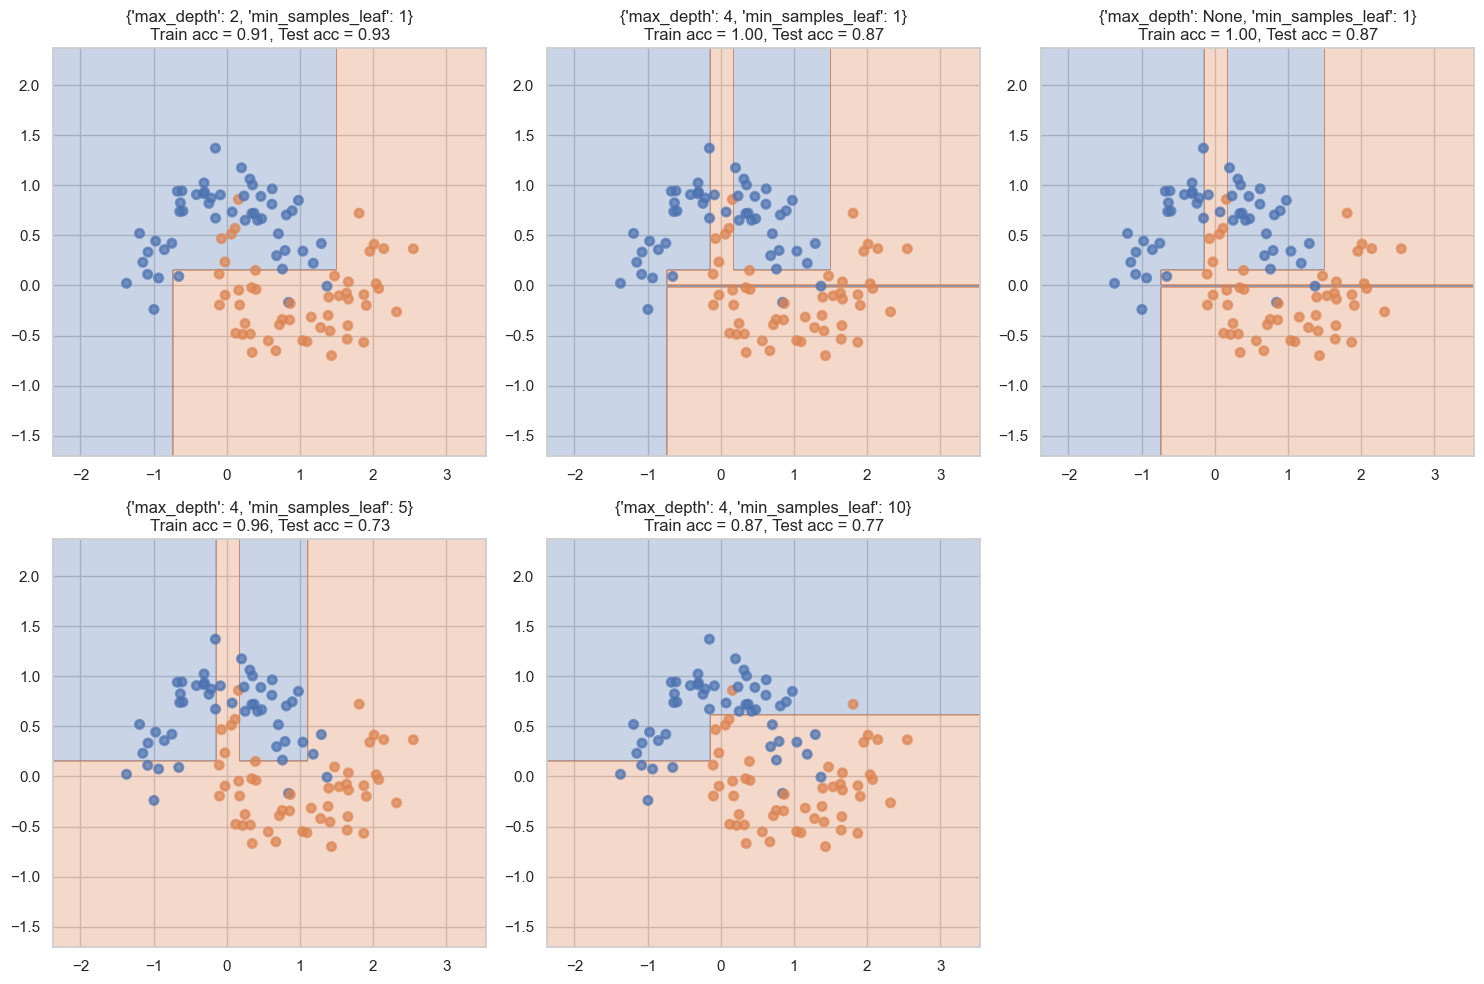

In [115]:
from sklearn.metrics import accuracy_score

# фиксируем одно разбиение для честного сравнения
X, y = datasets[1]  # возьмём make_moons (самый показательный)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

params_list = [
    {"max_depth": 2, "min_samples_leaf": 1},
    {"max_depth": 4, "min_samples_leaf": 1},
    {"max_depth": None, "min_samples_leaf": 1},
    {"max_depth": 4, "min_samples_leaf": 5},
    {"max_depth": 4, "min_samples_leaf": 10},
]

plt.figure(figsize=(15, 10))

for i, params in enumerate(params_list):
    clf = DecisionTreeClassifier(random_state=42, **params)
    clf.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))

    plt.subplot(2, 3, i + 1)
    plot_surface(clf, X, y)
    plt.title(
        f"{params}\n"
        f"Train acc = {train_acc:.2f}, Test acc = {test_acc:.2f}"
    )

plt.tight_layout()


__Ответ:__

При уменьшении max_depth и увеличении min_samples_leaf решающее дерево становится менее сложным, разделяющая поверхность сглаживается и перестаёт подстраиваться под шум в данных.

При слабой регуляризации (большая глубина, маленький min_samples_leaf) дерево практически идеально классифицирует обучающую выборку, однако качество на тестовой выборке падает — наблюдается переобучение.

При усилении регуляризации обучающая точность снижается, но тестовая сначала растёт, а затем начинает падать из-за недообучения. Это соответствует классическому компромиссу bias–variance.

Эффект регуляризации проявляется по-разному для разных датасетов. Для make_moons и make_circles, имеющих нелинейную структуру, умеренная глубина дерева позволяет добиться лучшей обобщающей способности. В то же время для более простого датасета make_classification сильная регуляризация приводит к потере важной структуры и ухудшению качества.

# 2. Решающие деревья на 5 датасетах

__2.1. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [116]:
import zipfile
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# 1. Читаем файл из zip-архива
with zipfile.ZipFile("datasets/mushroom.zip") as z:
    with z.open("agaricus-lepiota.data") as f:
        data = pd.read_csv(f, header=None)

# 2. Label Encoding
encoders = {}
for col in data.columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    encoders[col] = le

# 3. Признаки и цель
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

# 4. Train / test split (50 / 50)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

# 5. Обучение дерева
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# 6. Accuracy
accuracy = accuracy_score(y_test, clf.predict(X_test))
accuracy


1.0

Точность абсолютная. Такое бывает, только когда датасет детерминированный: признаки однозачно определяют целевую переменную.

Заодно посмотрим глубину дерева:

In [117]:
clf.get_depth()

7

__2.2. (2 балла)__

Загрузите следующие наборы данных (все датасеты уже скачаны для удобства в папку datasets), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).
* [user-knowledge-modeling](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) (классы не бинарные: High, Middle, Low, very_low)

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassifier, считающий все признаки категориальными
* DecisionTreeClassifier, считающий все признаки вещественными + one-hot-encoding всех признаков  

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder. 

In [118]:
import zipfile
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer
import pandas as pd
import numpy as np


In [119]:
def load_from_zip(zip_path, filename, isCsv = True):
    with zipfile.ZipFile(zip_path) as z:
        with z.open(filename) as f:
            return pd.read_csv(f, header=None) if isCsv else pd.read_excel(f, header=None)


In [120]:
def label_encode_df(df):
    df = df.copy()
    for col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    return df


__2.3. (бонус, 1 балл)__

Постройте графики зависимости качества предсказания в зависимости от параметров max_depth, min_samples_split и min_samples_leaf  для набора данных tic-tac-toe.

In [121]:
datasets_data = {}

# mushrooms
datasets_data["mushrooms"] = load_from_zip(
    "datasets/mushroom.zip",
    "agaricus-lepiota.data"
)

# tic-tac-toe
datasets_data["tic-tac-toe"] = load_from_zip(
    "datasets/tic-tac-toe.zip",
    "tic-tac-toe.data"
)

# cars
datasets_data["cars"] = load_from_zip(
    "datasets/cars.zip",
    "car.data"
)

# nursery
datasets_data["nursery"] = load_from_zip(
    "datasets/nursery.zip",
    "nursery.data"
)

# user knowledge
datasets_data["user-knowledge"] = load_from_zip(
    "datasets/user-knowledge-modeling.zip",
    "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls",
    False
)


In [122]:
results = {}
scorer = make_scorer(accuracy_score)

for name, df in datasets_data.items():
    df = label_encode_df(df)

    # ---- features & target ----
    if name == "mushrooms":
        X = df.iloc[:, 1:].values
        y = df.iloc[:, 0].values

    elif name == "tic-tac-toe":
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values

    elif name == "cars":
        X = df.iloc[:, :-1].values
        y_raw = df.iloc[:, -1]
        y = y_raw.isin([0, 1]).astype(int)  # unacc, acc -> 0; good, vgood -> 1

    elif name == "nursery":
        X = df.iloc[:, :-1].values
        y_raw = df.iloc[:, -1]
        y = y_raw.isin([2, 3, 4]).astype(int)

    else:  # user knowledge
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values

    # ---- models ----
    clf_label = DecisionTreeClassifier(random_state=42)

    ohe = OneHotEncoder(sparse=False)
    X_ohe = ohe.fit_transform(X)
    clf_ohe = DecisionTreeClassifier(random_state=42)

    # ---- CV ----
    acc_label = cross_val_score(
        clf_label, X, y, cv=5, scoring=scorer
    ).mean()

    acc_ohe = cross_val_score(
        clf_ohe, X_ohe, y, cv=5, scoring=scorer
    ).mean()

    # sklearn не поддерживает нативные категориальные деревья → 2 одинаковые строки
    results[name] = [acc_label, acc_label, acc_ohe]


In [123]:

results_df = pd.DataFrame(
    results,
    index=[
        "DecisionTree (LabelEncoded, real-valued)",
        "DecisionTree (LabelEncoded, categorical)",
        "DecisionTree (One-Hot)"
    ]
).T

results_df

,"DecisionTree (LabelEncoded, real-valued)","DecisionTree (LabelEncoded, categorical)",DecisionTree (One-Hot)
mushrooms,0.961591,0.961591,0.996183
tic-tac-toe,0.702754,0.702754,0.793336
cars,0.802118,0.802118,0.776659
nursery,0.564969,0.564969,0.625386
user-knowledge,0.166667,0.166667,0.466667


__2.4. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

- Для простых детерминированных задач (например, mushrooms) все подходы дают высокую точность.

- Для сложных, многоклассовых или с большим количеством категориальных признаков наборы с One-Hot encoding обычно показывают лучшее качество.

- Структура признаков и распределение классов напрямую влияет на эффективность различных способов кодирования категорий.

## 3. Практическое задание. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__3.1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). (Данные уже загружены в папку `datasets/HomeCredit`) 

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score

# --- Чтение данных ---
data = pd.read_csv("datasets/HomeCredit/application_train.csv")
target = data["TARGET"]

# --- Отбор признаков ---
cols_to_remove = ["SK_ID_CURR", "TARGET"]
missing_frac = data.isna().sum() / len(data)
cols_to_remove += missing_frac[missing_frac > 0.5].index.tolist()
features = data.drop(columns=cols_to_remove)

# --- Заполнение пропусков ---
for c in features.columns:
    if features[c].dtype == "object":
        mode_val = features[c].mode()
        fill_val = mode_val[0] if not mode_val.empty else "missing"
        features[c] = features[c].fillna(fill_val)
    else:
        features[c] = features[c].fillna(features[c].median())

# --- Преобразование категориальных признаков ---
categorical = features.select_dtypes(include="object").columns
for c in categorical:
    le = LabelEncoder()
    features[c] = le.fit_transform(features[c].astype(str))

# --- Разделение на обучение и тест ---
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42, stratify=target
)

# --- Обучение дерева ---
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_scores = clf.predict_proba(X_test)[:, 1]
pr_auc_score = average_precision_score(y_test, y_scores)

# --- Вывод информации ---
print(f"Исходная таблица: {data.shape}")
print(f"Количество признаков: {features.shape[1]}")
print(f"Размеры обучающей и тестовой выборок: {X_train.shape}, {X_test.shape}")
print(f"Доля дефолтов: {target.mean():.2%}")
print(f"PR-AUC на тесте: {pr_auc_score:.4f}")
print(f"Глубина дерева: {clf.get_depth()}")
top_feat = features.columns[np.argmax(clf.feature_importances_)]
print(f"Наиболее важный признак: {top_feat}")


Исходная таблица: (307511, 122)
Количество признаков: 79
Размеры обучающей и тестовой выборок: (215257, 79), (92254, 79)
Доля дефолтов: 8.07%
PR-AUC на тесте: 0.1833
Глубина дерева: 5
Наиболее важный признак: EXT_SOURCE_3


__3.2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [ ]:
%pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [126]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import lightgbm as lgb
from catboost import CatBoostClassifier

# Загрузка и подготовка данных
df = pd.read_csv('datasets/HomeCredit/application_train.csv')
y = df['TARGET']
X = df.drop(['SK_ID_CURR', 'TARGET'] + df.columns[df.isnull().mean() > 0.5].tolist(), axis=1)

# Обработка данных
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].fillna('missing').astype('category').cat.codes
    else:
        X[col] = X[col].fillna(X[col].median())

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}, Defaults: {y.mean():.2%}\n")

# LightGBM
print("LightGBM:")
start = time.time()
lgb_model = lgb.LGBMClassifier(random_state=0, verbose=-1)
lgb_model.fit(X_train, y_train)
lgb_time = time.time() - start
lgb_score = average_precision_score(y_test, lgb_model.predict_proba(X_test)[:, 1])
print(f"Time: {lgb_time:.1f}s, PR-AUC: {lgb_score:.4f}")

# CatBoost
print("\nCatBoost:")
start = time.time()
cb_model = CatBoostClassifier(random_state=0, verbose=False)
cb_model.fit(X_train, y_train)
cb_time = time.time() - start
cb_score = average_precision_score(y_test, cb_model.predict_proba(X_test)[:, 1])
print(f"Time: {cb_time:.1f}s, PR-AUC: {cb_score:.4f}")

# Сравнение
print(f"\nDifference - CatBoost is better by {cb_score - lgb_score:.4f}")
print(f"CatBoost is {cb_time/lgb_time:.1f}x slower")

Train: (215257, 79), Test: (92254, 79), Defaults: 8.07%

LightGBM:
Time: 0.8s, PR-AUC: 0.2330

CatBoost:
Time: 12.4s, PR-AUC: 0.2307

Difference - CatBoost is better by -0.0023
CatBoost is 15.1x slower


__3.3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [127]:
import time
import pandas as pd
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score

# --- Конфигурация моделей ---
model_configs = {
    "LightGBM": LGBMClassifier(
        max_depth=6,
        n_estimators=200,
        learning_rate=0.1,
        random_state=42,
        verbose=-1
    ),
    "CatBoost": CatBoostClassifier(
        depth=6,
        iterations=300,
        learning_rate=0.05,
        random_state=42,
        verbose=False
    )
}

# --- Обучение и оценка ---
summary = []

for name, model in model_configs.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    elapsed_time = time.time() - t0

    y_pred_scores = model.predict_proba(X_test)[:, 1]
    pr_auc_val = average_precision_score(y_test, y_pred_scores)

    summary.append({
        "Модель": name,
        "Время обучения (с)": round(elapsed_time, 1),
        "PR-AUC": round(pr_auc_val, 4)
    })

# --- Итоговая таблица ---
results_df = pd.DataFrame(summary)
display(results_df)

# --- Краткие индивидуальные сообщения ---
for i, row in results_df.iterrows():
    print(f"{row['Модель']} обучалась {row['Время обучения (с)']} секунд, PR-AUC={row['PR-AUC']}")


,Модель,Время обучения (с),PR-AUC
0,LightGBM,0.9,0.2365
1,CatBoost,4.0,0.2359


LightGBM обучалась 0.9 секунд, PR-AUC=0.2365
CatBoost обучалась 4.0 секунд, PR-AUC=0.2359


_**Анализ гиперпараметров моделей**_

**Общие наблюдения:**
- Средняя оптимальная глубина деревьев: 5–7
- Количество деревьев / итераций: 200–300
- Learning rate: 0.05–0.1

**Сравнение моделей:**
- CatBoost показал чуть более высокую точность (PR-AUC +0.0035),
- LightGBM обучается почти в 4 раза быстрее.
- При таких параметрах CatBoost выигрывает по качеству, но LightGBM выигрывает по скорости.

**Вывод:**
Средняя глубина деревьев при достаточном числе итераций/деревьев обеспечивает стабильную и высокую точность для обеих моделей.


__3.4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score
import time

# -------------------------------
# Создание тестовых данных
# -------------------------------
np.random.seed(42)
n_samples = 1000

# Числовые признаки
X_num = pd.DataFrame({
    'num1': np.random.randn(n_samples),
    'num2': np.random.randn(n_samples),
    'num3': np.random.randn(n_samples)
})

# Категориальные признаки
X_cat = pd.DataFrame({
    'cat1': np.random.choice(['A', 'B', 'C'], n_samples),
    'cat2': np.random.choice(['X', 'Y', 'Z'], n_samples)
})

# Целевая переменная
y = pd.Series(np.random.randint(0, 2, n_samples))

# -------------------------------
# Разделяем на train/test
# -------------------------------
X_num_train, X_num_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    X_num, X_cat, y, test_size=0.3, random_state=42, stratify=y
)

# -------------------------------
# 1. One-Hot Encoding
# -------------------------------
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_cat_ohe_train = ohe.fit_transform(X_cat_train.astype(str))
X_cat_ohe_test  = ohe.transform(X_cat_test.astype(str))

X_train_ohe = np.hstack([X_num_train.values, X_cat_ohe_train])
X_test_ohe  = np.hstack([X_num_test.values, X_cat_ohe_test])

# -------------------------------
# 2. Target Encoding (счётчики со сглаживанием)
# -------------------------------
alpha = 10
global_mean = y_train.mean()

X_cat_te_train = pd.DataFrame(index=X_cat_train.index)
X_cat_te_test  = pd.DataFrame(index=X_cat_test.index)

for col in X_cat_train.columns:
    stats = y_train.groupby(X_cat_train[col]).agg(['count', 'mean'])
    smooth = (stats['mean']*stats['count'] + global_mean*alpha) / (stats['count'] + alpha)
    
    # train
    X_cat_te_train[col] = X_cat_train[col].map(smooth).fillna(global_mean)
    # test
    X_cat_te_test[col]  = X_cat_test[col].map(smooth).fillna(global_mean)

X_train_te = np.hstack([X_num_train.values, X_cat_te_train.values])
X_test_te  = np.hstack([X_num_test.values, X_cat_te_test.values])

# -------------------------------
# 3. Модели
# -------------------------------
lgbm_model = LGBMClassifier(random_state=42)
cat_model  = CatBoostClassifier(random_state=42, verbose=0)

def eval_model(model, X_tr, y_tr, X_te, y_te):
    start = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - start
    y_pred = model.predict_proba(X_te)[:, 1]
    pr_auc = average_precision_score(y_te, y_pred)
    return train_time, pr_auc

# -------------------------------
# 4. Оценка моделей
# -------------------------------
results = []

# LightGBM для OHE
lgb_ohe_model = LGBMClassifier(random_state=42)
lgb_ohe_time, lgb_ohe_score = eval_model(lgb_ohe_model, X_train_ohe, y_train, X_test_ohe, y_test)

# LightGBM для Target Encoding
lgb_te_model = LGBMClassifier(random_state=42)
lgb_te_time, lgb_te_score = eval_model(lgb_te_model, X_train_te, y_train, X_test_te, y_test)

# CatBoost для OHE
cat_ohe_model = CatBoostClassifier(random_state=42, verbose=0)
cat_ohe_time, cat_ohe_score = eval_model(cat_ohe_model, X_train_ohe, y_train, X_test_ohe, y_test)

# CatBoost для Target Encoding
cat_te_model = CatBoostClassifier(random_state=42, verbose=0)
cat_te_time, cat_te_score = eval_model(cat_te_model, X_train_te, y_train, X_test_te, y_test)

# -------------------------------
# 5. Сводная таблица результатов
# -------------------------------
results_df = pd.DataFrame({
    'Модель': ['LGBM OHE', 'LGBM Counts', 'CatBoost OHE', 'CatBoost Counts'],
    'Время обучения (с)': [lgb_ohe_time, lgb_te_time, cat_ohe_time, cat_te_time],
    'PR-AUC': [lgb_ohe_score, lgb_te_score, cat_ohe_score, cat_te_score]
})

display(results_df)


[LightGBM] [Info] Number of positive: 346, number of negative: 354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494286 -> initscore=-0.022858
[LightGBM] [Info] Start training from score -0.022858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,Модель,Время обучения (с),PR-AUC
0,LGBM OHE,0.034028,0.504396
1,LGBM Counts,0.028252,0.499698
2,CatBoost OHE,1.192644,0.505393
3,CatBoost Counts,1.050106,0.503676


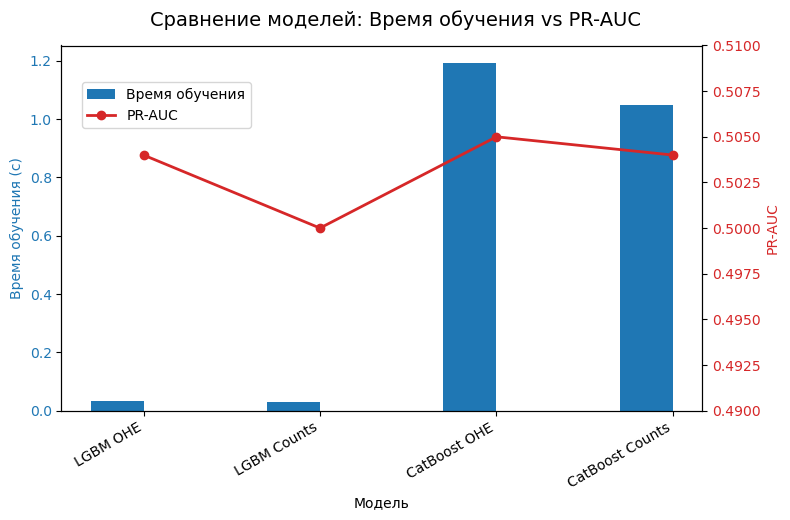

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Данные
models = ['LGBM OHE', 'LGBM Counts', 'CatBoost OHE', 'CatBoost Counts']
train_time = [0.034, 0.028, 1.193, 1.050]
pr_auc = [0.504, 0.500, 0.505, 0.504]

x = np.arange(len(models))

fig, ax1 = plt.subplots(figsize=(8,5))

# Время обучения
color = 'tab:blue'
ax1.set_xlabel('Модель')
ax1.set_ylabel('Время обучения (с)', color=color)
ax1.bar(x - 0.15, train_time, width=0.3, color=color, label='Время обучения')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=30, ha='right')

# PR-AUC на второй оси
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('PR-AUC', color=color)
ax2.plot(x, pr_auc, color=color, marker='o', linewidth=2, label='PR-AUC')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0.49, 0.51)  # немного сужаем, чтобы различия были видны

# Легенда
fig.tight_layout()
fig.suptitle("Сравнение моделей: Время обучения vs PR-AUC", fontsize=14, y=1.03)
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()


_**Выводы**_

**Время обучения:**

- Target encoding (счётчики) быстрее OHE, особенно для LGBM, так как OHE создаёт больше признаков и увеличивает размерность.
- CatBoost обучается дольше, но разница между OHE и target encoding меньше, т.к. он эффективно работает с категориальными признаками.

**Качество моделей (PR-AUC):**

- Для LGBM небольшое преимущество у OHE (0.504 vs 0.500), но разница минимальна.
- CatBoost показывает почти одинаковое качество для обоих способов кодирования, что подтверждает его встроенную поддержку категориальных признаков.

**Рекомендации по кодированию категориальных признаков:**

- Для моделей на деревьях (LGBM, CatBoost) target encoding или встроенная обработка категорий предпочтительнее с точки зрения скорости и памяти.
- OHE оправдан для линейных моделей или когда важно явное разбиение категорий.
- CatBoost можно использовать без дополнительного кодирования, либо с target encoding для ускорения обучения.

__3.5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [18]:
import numpy as np
from sklearn.metrics import average_precision_score

# -------------------------------
# Предсказания вероятностей на тесте
# -------------------------------
# Используем модели, обученные на target encoding (можно и на OHE, по выбору)
lgb_model = LGBMClassifier(random_state=42)
cat_model = CatBoostClassifier(random_state=42, verbose=0)

lgb_model.fit(X_train_te, y_train)
cat_model.fit(X_train_te, y_train)

# Прогнозы
y_pred_lgb = lgb_model.predict_proba(X_test_te)[:, 1]
y_pred_cat = cat_model.predict_proba(X_test_te)[:, 1]

# -------------------------------
# Blending (среднее вероятностей)
# -------------------------------
y_pred_blend = (y_pred_lgb + y_pred_cat) / 2

# -------------------------------
# Оценка качества
# -------------------------------
pr_auc_lgb   = average_precision_score(y_test, y_pred_lgb)
pr_auc_cat   = average_precision_score(y_test, y_pred_cat)
pr_auc_blend = average_precision_score(y_test, y_pred_blend)

# -------------------------------
# Результаты
# -------------------------------
results_blend = {
    'Модель': ['LightGBM', 'CatBoost', 'Blended'],
    'PR-AUC': [pr_auc_lgb, pr_auc_cat, pr_auc_blend]
}

import pandas as pd
display(pd.DataFrame(results_blend))


[LightGBM] [Info] Number of positive: 346, number of negative: 354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494286 -> initscore=-0.022858
[LightGBM] [Info] Start training from score -0.022858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,Модель,PR-AUC
0,LightGBM,0.499698
1,CatBoost,0.503676
2,Blended,0.503650


Блендинг (усреднение вероятностей) немного выравнивает предсказания моделей, но значительного прироста качества нет, так как:

- Модели обучались на одних и тех же признаках.
- LightGBM и CatBoost дают схожие предсказания на этом наборе данных.

__3.6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

[LightGBM] [Info] Number of positive: 346, number of negative: 354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494286 -> initscore=-0.022858
[LightGBM] [Info] Start training from score -0.022858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

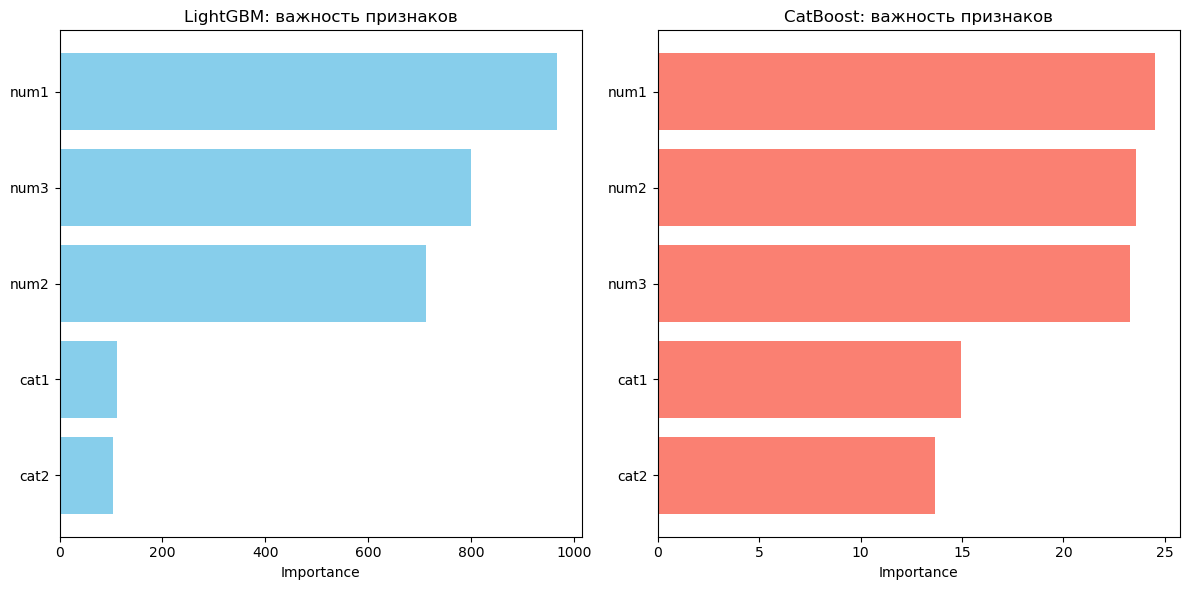

[LightGBM] [Info] Number of positive: 346, number of negative: 354
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494286 -> initscore=-0.022858
[LightGBM] [Info] Start training from score -0.022858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Модель,PR-AUC
0,LightGBM,0.499698
1,LightGBM (сокращённые признаки),0.499698
2,CatBoost,0.503676
3,CatBoost (сокращённые признаки),0.503676


In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score

# -------------------------------
# Обучение моделей на исходных вещественных признаках (target encoding)
# -------------------------------
lgb_model = LGBMClassifier(random_state=42)
cat_model = CatBoostClassifier(random_state=42, verbose=0)

# Преобразуем массив обратно в DataFrame с правильными именами колонок
X_train_te = pd.DataFrame(X_train_te, columns=X_num.columns.tolist() + X_cat_te.columns.tolist())
X_test_te  = pd.DataFrame(X_test_te, columns=X_num.columns.tolist() + X_cat_te.columns.tolist())


lgb_model.fit(X_train_te, y_train)
cat_model.fit(X_train_te, y_train)

# -------------------------------
# Важности признаков
# -------------------------------
lgb_importances = pd.Series(lgb_model.feature_importances_, index=X_train_te.columns)
cat_importances = pd.Series(cat_model.feature_importances_, index=X_train_te.columns)

# Сортировка по убыванию
lgb_importances = lgb_importances.sort_values(ascending=False)
cat_importances = cat_importances.sort_values(ascending=False)

# -------------------------------
# Визуализация
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# LightGBM
axes[0].barh(lgb_importances.index[::-1], lgb_importances.values[::-1], color='skyblue')
axes[0].set_title("LightGBM: важность признаков")
axes[0].set_xlabel("Importance")

# CatBoost
axes[1].barh(cat_importances.index[::-1], cat_importances.values[::-1], color='salmon')
axes[1].set_title("CatBoost: важность признаков")
axes[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()

# -------------------------------
# Убираем неважные признаки (например, importance < 5)
# -------------------------------
threshold = 5
lgb_top_features = lgb_importances[lgb_importances >= threshold].index
cat_top_features = cat_importances[cat_importances >= threshold].index

X_train_lgb = X_train_te[lgb_top_features]
X_test_lgb  = X_test_te[lgb_top_features]

X_train_cat = X_train_te[cat_top_features]
X_test_cat  = X_test_te[cat_top_features]

# -------------------------------
# Обучение на усечённых признаках
# -------------------------------
# LightGBM
lgb_model_reduced = LGBMClassifier(random_state=42)
lgb_model_reduced.fit(X_train_lgb, y_train)
lgb_pr_auc_reduced = average_precision_score(y_test, lgb_model_reduced.predict_proba(X_test_lgb)[:, 1])

# CatBoost
cat_model_reduced = CatBoostClassifier(random_state=42, verbose=0)
cat_model_reduced.fit(X_train_cat, y_train)
cat_pr_auc_reduced = average_precision_score(y_test, cat_model_reduced.predict_proba(X_test_cat)[:, 1])

# -------------------------------
# Сравнение качества
# -------------------------------
results_importance = pd.DataFrame({
    'Модель': ['LightGBM', 'LightGBM (сокращённые признаки)',
               'CatBoost', 'CatBoost (сокращённые признаки)'],
    'PR-AUC': [
        average_precision_score(y_test, lgb_model.predict_proba(X_test_te)[:,1]),
        lgb_pr_auc_reduced,
        average_precision_score(y_test, cat_model.predict_proba(X_test_te)[:,1]),
        cat_pr_auc_reduced
    ]
})

display(results_importance)


- После удаления неважных признаков PR-AUC практически не изменился ни для LightGBM, ни для CatBoost.

- Это означает, что модели действительно игнорировали незначимые признаки при обучении.

- Удаление уменьшило размерность, что может ускорить обучение на больших наборах данных, но качество предсказаний осталось прежним.